# Trabalhando com previsões em séries temporais

## Bibliotecas comuns

In [64]:
# !pip install seaborn==0.11.1
# !pip install statsmodels==v0.11.0rc2

import pandas as pd
import seaborn as sns
import statsmodels as sm
import numpy as np

sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize": (11.7, 8.27)})


## Explorando os dados

In [2]:
df_nasc = pd.read_csv("databases/nascimentos.csv")
df_nasc

,data,n_nasc
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [3]:
from pandas.plotting import register_matplotlib_converters

# Se tentarmos plotar o gráfico com a informação original do dataset
# teremos alguns problemas pois a coluna X nesse caso é uma data, precisamos
# converter esta data para datetime e então "informar" que essa conversão
# foi feita para o seaborn

df_nasc["data"] = pd.to_datetime(df_nasc["data"])
register_matplotlib_converters()

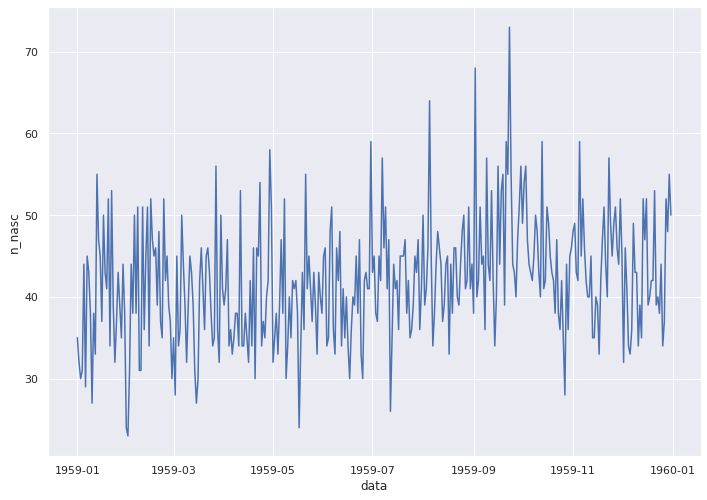

In [4]:
ax = sns.lineplot(x="data", y="n_nasc", data=df_nasc)

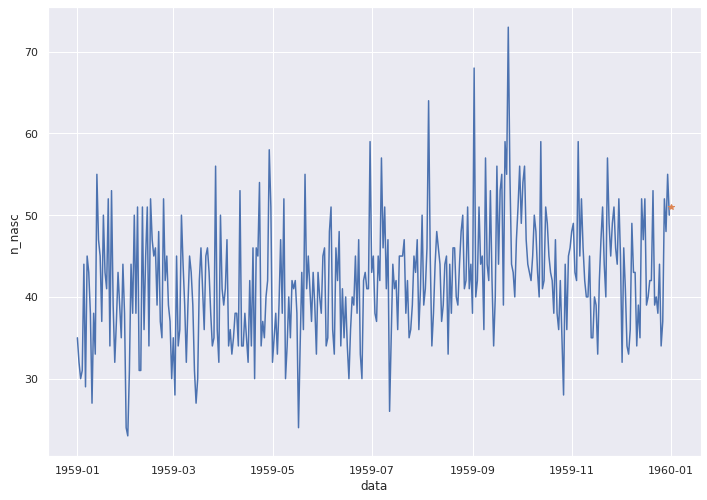

In [5]:
# Tentando gerar a próxima estimativa através da média dos N ultimos registros
N = 3

next_y = df_nasc.tail(N)["n_nasc"].mean()

shape = df_nasc.shape[0]
next_x = df_nasc["data"][shape - 1] + (df_nasc["data"][shape - 1] - df_nasc["data"][shape - 2])


ax = sns.lineplot(x="data", y="n_nasc", data=df_nasc)
ax = ax.plot(next_x, next_y, "*")


## Tratamento dos dados

In [11]:
# Calculando a média móvel com agrupamento de N em N
N = 5
media_movel_nasc = df_nasc.rolling(N).mean()
media_movel_nasc

,n_nasc
0,NaN
1,NaN
2,NaN
3,NaN
4,34.4
...,...
360,38.6
361,41.0
362,43.0
363,45.2


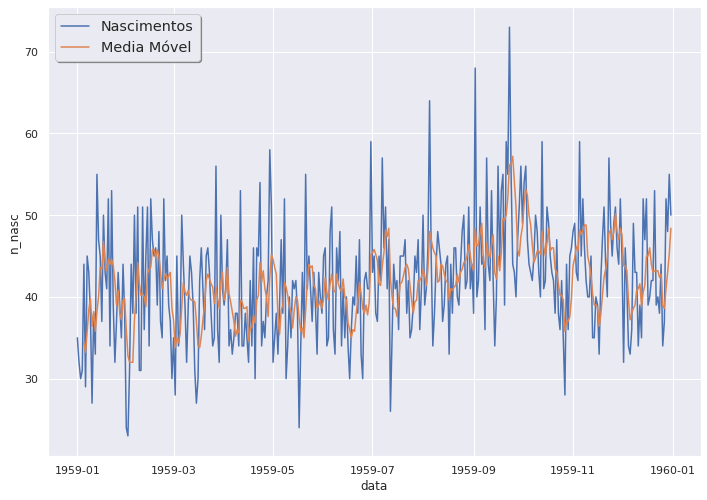

In [19]:
ax = sns.lineplot(x="data", y="n_nasc", data=df_nasc, label="Nascimentos")

# Precisei colocar a referência de data do dataframe original
ax.plot(df_nasc["data"], media_movel_nasc["n_nasc"], label="Media Móvel")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

P = 35 # dias
decompose = seasonal_decompose(df_nasc.set_index("data"), period=P)

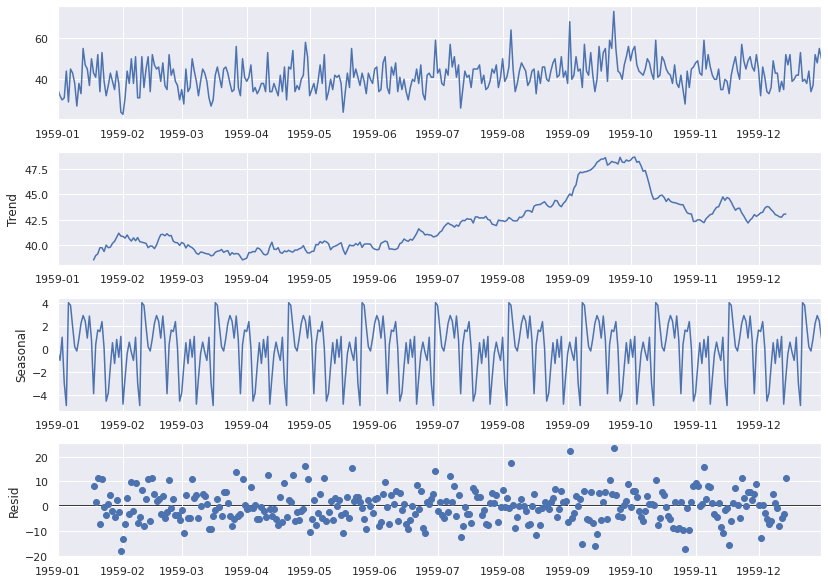

In [23]:
# O ; indica que deve plotar apenas um grupo de gráficos, caso não coloque ele gera dois grupos iguais
decompose.plot();

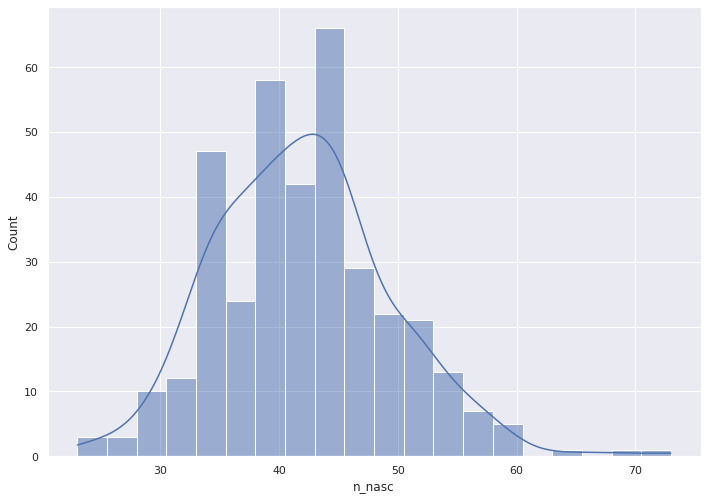

In [31]:
ax = sns.histplot(data=df_nasc, x="n_nasc", kde=True)

In [32]:
half = int(df_nasc.shape[0] / 2)
values = df_nasc["n_nasc"].values

first_half, second_half = values[0:half], values[half:]

In [33]:
# Calculando a variação da média
media_first = first_half.mean()
media_second = second_half.mean()

print(f"Média 1º Metade: {media_first}\nMédia 2º Metade: {media_second}")

Média 1º Metade: 39.76373626373626
Média 2º Metade: 44.185792349726775


- Existe uma pequena variação da média, mais um ponto que indica a não estacionaridade

In [34]:
# Calculando a variação
var_first = first_half.var()
var_second = second_half.var()

print(f"Var 1º Metade: {var_first}\nVar 2º Metade: {var_second}")

Var 1º Metade: 49.21341021615746
Var 2º Metade: 48.708650601690096


- Neste caso, a pequena variação indica que a série é estacionária

### Teste ADF (Verificar a estacionariedade da série)

In [35]:
from statsmodels.tsa.stattools import adfuller

In [38]:
resultado = adfuller(df_nasc["n_nasc"].values)

# Quanto mais negativo mais estacionária é a série
print(f"Estatistica ADF: {resultado[0]}")
print(f"P-Value: {resultado[1]}")

Estatistica ADF: -4.808291253559765
P-Value: 5.2434129901498554e-05


- Neste teste obtivemos um valor negativo para o ADF, o que infere que a série é estacionária
- P-Value <= 0.05 indica que a série é estacionária

## Diferenciação da série temporal

In [41]:
df_nasc["diff"] = df_nasc["n_nasc"].diff()
df_nasc

,data,n_nasc,diff
0,1959-01-01,35,NaN
1,1959-01-02,32,-3.0
2,1959-01-03,30,-2.0
3,1959-01-04,31,1.0
4,1959-01-05,44,13.0
...,...,...,...
360,1959-12-27,37,3.0
361,1959-12-28,52,15.0
362,1959-12-29,48,-4.0
363,1959-12-30,55,7.0


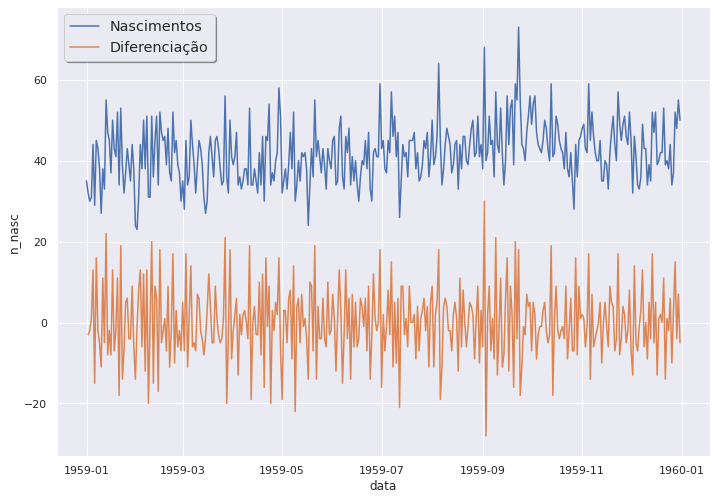

In [42]:
ax = sns.lineplot(x="data", y="n_nasc", data=df_nasc, label="Nascimentos")

ax.plot(df_nasc["data"], df_nasc["diff"], label="Diferenciação")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

## Treinamento do modelo

### Método de Suavização Exponencial

In [43]:
df_train = df_nasc[["data", "n_nasc"]].set_index("data")
df_train

,n_nasc
data,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [44]:
train = df_train["1959-01-01":"1959-12-01"]
test = df_train["1959-12-01":]

In [45]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [69]:
model_smoothing = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

/home/davidm/miniconda3/envs/data/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [70]:
predict_smoothing = model_smoothing.forecast(test.shape[0])

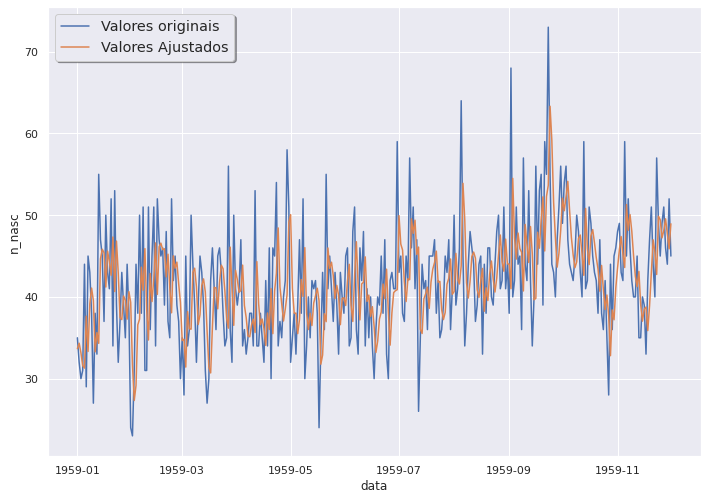

In [71]:
ax = sns.lineplot(x="data", y="n_nasc", data=train, label="Valores originais")
ax.plot(train.index, model_smoothing.fittedvalues.values, label="Valores Ajustados")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

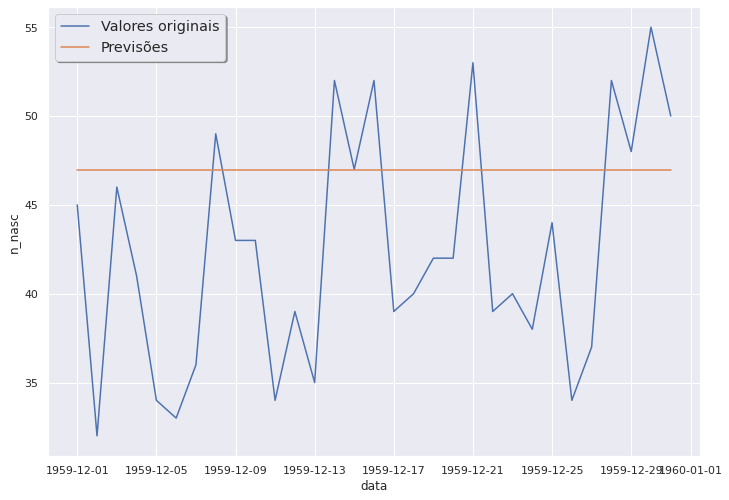

In [72]:
ax = sns.lineplot(x="data", y="n_nasc", data=test, label="Valores originais")
ax.plot(test.index, predict_smoothing, label="Previsões")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

### Método Holt-Winters

- Suavização exponencial de terceira ordem

- Modelo Aditivo:
`Y_t = Nível + Tendência + Sazonalidade + Ruído`

- Modelo Multiplicativo:
`Y_t = Nível * Tendência * Sazonalidade * Ruído`


#### Tendência Aditiva

`E_(t + k) = N_t + k(T_t)

In [51]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [73]:
period = 35

model_hw = ExponentialSmoothing(
    train.values,
    trend="additive",
    seasonal="additive",
    seasonal_periods=period
).fit()

/home/davidm/miniconda3/envs/data/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:735: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [53]:
tr_s = train.shape[0]
te_s = test.shape[0]
print(f"Pontos no banco de treino: {tr_s}\nPontos no banco de testes: {te_s}")

start = tr_s
end = start + te_s - 1

print(f"\nIntervalo de predição: ({start}, {end})")

Pontos no banco de treino: 335
Pontos no banco de testes: 31

Intervalo de predição: (335, 365)


In [74]:
predict_hw = model_hw.predict(start=start, end=end)

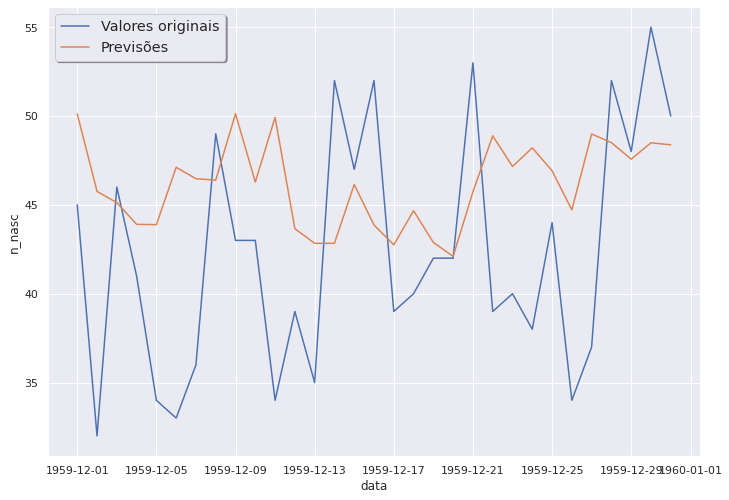

In [75]:
ax = sns.lineplot(x=test.index, y="n_nasc", data=test, label="Valores originais")
ax.plot(test.index, predict_hw, label="Previsões")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

## Correlação e Autocorrelação

- Identificando sazonalidade

In [58]:
from statsmodels.graphics.tsaplots import plot_acf

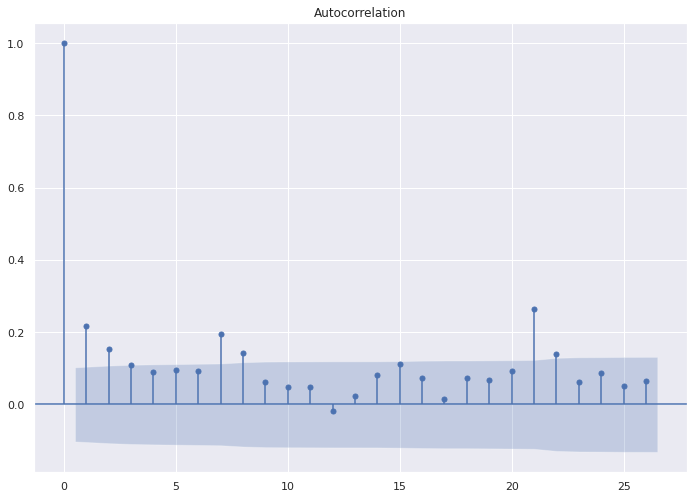

In [59]:
plot_acf(df_nasc["n_nasc"]);

### Autocorrelação parcial

In [60]:
from statsmodels.graphics.tsaplots import plot_pacf

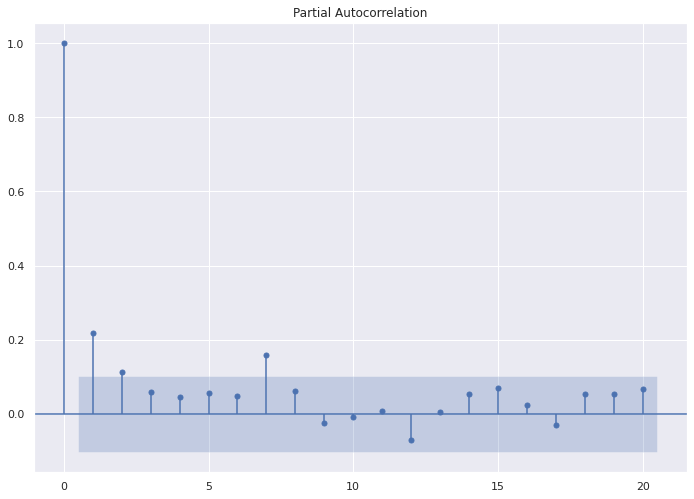

In [61]:
plot_pacf(df_nasc["n_nasc"], lags=20);

In [62]:
from statsmodels.tsa.ar_model import AutoReg

In [76]:
lags_list = np.linspace(1, 40, 40)
period = 35

model_ar = AutoReg(train.values, lags=lags_list, trend="c", seasonal=True, period=period).fit()

In [77]:
predict_ar = model_ar.predict(start=start, end=end)

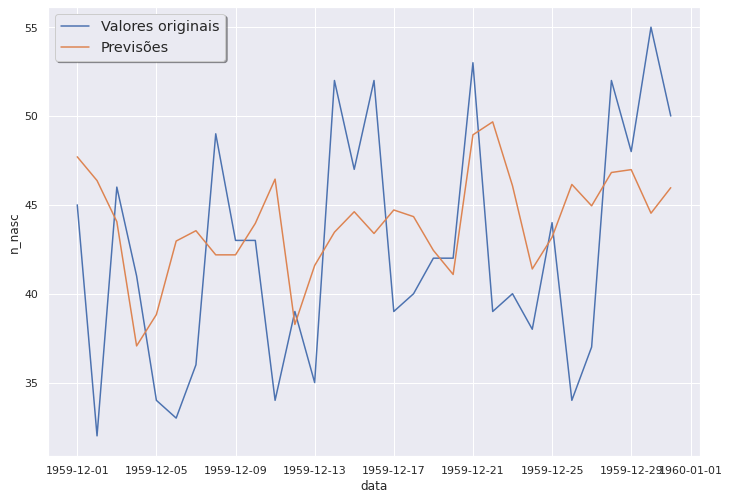

In [78]:
ax = sns.lineplot(x=test.index, y="n_nasc", data=test, label="Valores originais")
ax.plot(test.index, predict_ar, label="Previsões")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

## Verificando o desempenho

- ExpSmoothing x Holt-Winters x Autoregressivo

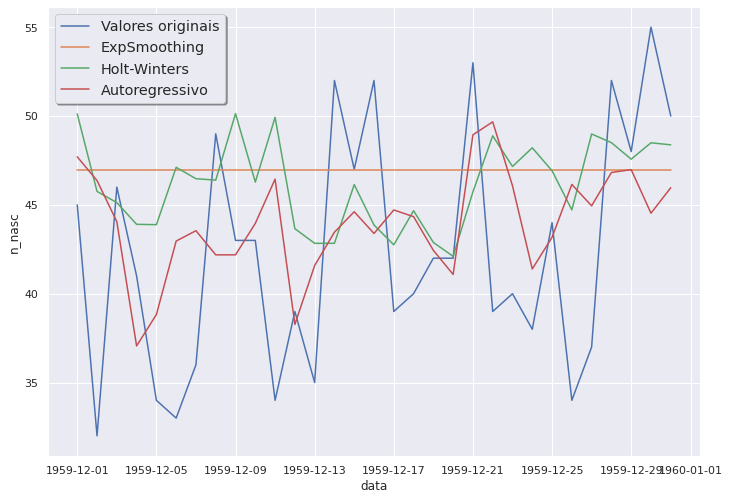

In [83]:
ax = sns.lineplot(x=test.index, y="n_nasc", data=test, label="Valores originais")
ax.plot(test.index, predict_smoothing, label="ExpSmoothing")
ax.plot(test.index, predict_hw, label="Holt-Winters")
ax.plot(test.index, predict_ar, label="Autoregressivo")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

In [86]:
error_pred_smoothing = test["n_nasc"] - np.array(predict_smoothing)
error_pred_hw = test["n_nasc"] - predict_hw
error_pred_ar = test["n_nasc"] - predict_ar

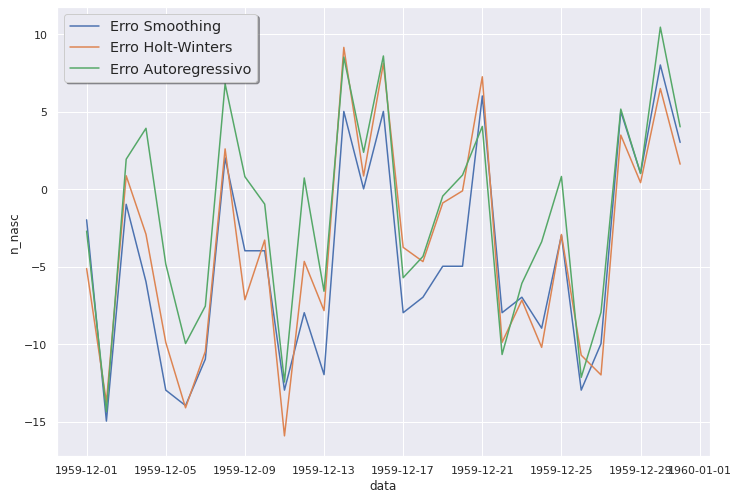

In [87]:
ax = sns.lineplot(x=test.index, y=error_pred_smoothing, label="Erro Smoothing")
ax.plot(test.index, error_pred_hw, label="Erro Holt-Winters")
ax.plot(test.index, error_pred_ar, label="Erro Autoregressivo")

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

In [90]:
mean_error_smoothing = np.mean(error_pred_smoothing).round(3)
mean_error_hw = np.mean(error_pred_hw).round(3)
mean_error_ar = np.mean(error_pred_ar).round(3)

print(f"Erro Médio Smoothing: {mean_error_smoothing}")
print(f"Erro Médio Holt-Winters: {mean_error_hw}")
print(f"Erro Médio Autoregressivo: {mean_error_ar}")

Erro Médio Smoothing: -4.585
Erro Médio Holt-Winters: -3.756
Erro Médio Autoregressivo: -1.608


In [97]:
from sklearn.metrics import mean_absolute_error

# Podemos calcular também através das metricas do sklearn

In [101]:
mae_smoothing = mean_absolute_error(test["n_nasc"], predict_smoothing)
mae_hw = mean_absolute_error(test["n_nasc"], predict_hw)
mae_ar = mean_absolute_error(test["n_nasc"], predict_ar)

print(f"Erro Médio Abs Smoothing: {mae_smoothing}")
print(f"Erro Médio Abs Holt-Winters: {mae_hw}")
print(f"Erro Médio Abs Autoregressivo: {mae_ar}")

Erro Médio Abs Smoothing: 6.859293147383144
Erro Médio Abs Holt-Winters: 6.398237208033461
Erro Médio Abs Autoregressivo: 5.496720548092109
